In [ ]:
import os
import numpy as np
import soundfile as sf
from scipy.signal import resample
from scipy.io.wavfile import write
from time import time

from clip_sdr_modified import clip_sdr_modified
from spade_segmentation import spade_segmentation
from sdr import sdr

# Helper function to ensure directories exist
def ensure_dir(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)
        print(f"Created directory: {directory}")
    else:
        print(f"Directory already exists: {directory}")


# Path to the audio files
audio_dir = "/mnt/External/8TBHDD/AAG/MTech_Project/sounds/Heart_sounds/"                   # input sounds directory 
output_path = "/mnt/External/8TBHDD/AAG/MTech_Project/diff_sdr/heart/sampling"              # output path

# Initialize variables
time_clip = [1,2]   #Time durations
target_fs_values = [1000,2000]  # Sampling frequencies 
clipping_thresholds = [0.15,0.25,0.35]  # Clipping thresholds

sdr_clip_mean_array = []    # Clipped signal sdr storage
sdr_clip_std_array = []
time_mean_array = []    
time_std_array = []
theta_c_mean_array = []
samples_clipped_mean_array = []
samples_clipped_std_array = []
sdr_imp_mean_array = []             # Tiem storage
sdr_imp_std_array = []

dynamic=1           # To enable dynamic aspade


for target_fs in target_fs_values:
    for clipping_threshold in clipping_thresholds:

        # Directory for the current target_fs and threshold combination
        dir_name = f"fs_{target_fs}_threshold_{clipping_threshold:.2f}"
        full_dir_path = os.path.join(output_path, dir_name)
        ensure_dir(full_dir_path)

        for tc in time_clip:
            wav_files = [f for f in os.listdir(audio_dir) if f.endswith(".wav")]
            n_files = len(wav_files)
            n_files=1      

            # Limit the files to process to 'n_files'
            wav_files = wav_files[:n_files]             

            sdr_clip_array = []
            time_array = []
            theta_c_array = []
            samples_clipped_array = []
            sdr_imp_array = []

            for i, audio_file in enumerate(wav_files):
                print(f"Loading audio: {audio_file}")
                data, fs = sf.read(os.path.join(audio_dir, audio_file))

                # Ensure mono signal
                if len(data.shape) > 1:
                    data = data[:, 0]

                data = data[: fs * tc]      # fs is original data sampling rate

                data = data / max(np.abs(data))         # normalization

                # Resample to target sampling frequency
                resampled_data = resample(data, int(target_fs * tc))

                Ls = len(resampled_data) # length of resampled (not original)
                inputTheta = clipping_threshold # threshold
                win_len = np.floor(Ls/2)  # window length
                win_shift = np.floor(win_len/4)   # window shift
                #win_type = 'hann'
                F_red = 2  # redundancy

                ps_s = 1    # s parameter
                ps_r = 2    # r parameter
                ps_epsilon = 0.1  # epsilon
                ps_maxit = np.ceil(np.floor(win_len * F_red / 2 + 1) * ps_r / ps_s)                 # max iterations

                print("Generating clipped signal \n")
                # Clipping
                clipped_signal, masks, theta, true_sdr, percentage = clip_sdr_modified(resampled_data, clipping_threshold)
                print(f"Clipping threshold {theta:.3f}, true SDR: {true_sdr:.2f} dB, Clipped samples: {percentage:.2f}%, Time: {tc}sec")
                

                # Reconstruction
                start_time = time()
                reconstructed_signal = spade_segmentation(clipped_signal, resampled_data, Ls, win_len, win_shift, ps_maxit, ps_epsilon, ps_r, ps_s, F_red, masks,dynamic)
                elapsed_time = time() - start_time

                reconstructed_signal = resample(reconstructed_signal, int(fs * tc))

                clipped_signal,_,_,_,_ = clip_sdr_modified(data, clipping_threshold)

                sdr_clip = sdr(data, clipped_signal)
                sdr_rec = sdr(data, reconstructed_signal)
                sdr_imp = sdr_rec - sdr_clip

                # Store metrics
                sdr_clip_array.append(sdr_clip)
                theta_c_array.append(theta)
                samples_clipped_array.append(percentage)
                sdr_imp_array.append(sdr_imp)
                time_array.append(elapsed_time)

                # Save audio files
                audios_dir = os.path.join(full_dir_path, "audios")
                ensure_dir(audios_dir)

                sf.write(os.path.join(audios_dir, f"{audio_file}_clipped_{tc}s.wav"), clipped_signal, target_fs)
                sf.write(os.path.join(audios_dir, f"{audio_file}_reconstructed_{tc}s.wav"), reconstructed_signal, fs)
                sf.write(os.path.join(audios_dir, f"{audio_file}_original_{tc}s.wav"), data, fs)

                      # Calculate mean and std
            sdr_clip_mean_array.append(np.mean(sdr_clip_array))
            sdr_clip_std_array.append(np.std(sdr_clip_array))
            theta_c_mean_array.append(np.mean(theta_c_array))
            samples_clipped_mean_array.append(np.mean(samples_clipped_array))
            samples_clipped_std_array.append(np.std(samples_clipped_array))
            sdr_imp_mean_array.append(np.mean(sdr_imp_array))
            sdr_imp_std_array.append(np.std(sdr_imp_array))
            time_mean_array.append(np.mean(time_array))
            time_std_array.append(np.std(time_array))

    # # Define the output filename
    # output_filename = f'Results_fs_{target_fs}_threshold_{clipping_threshold:.2f}.mat'

       

In [2]:
sdr_imp_mean = np.reshape(
    sdr_imp_mean_array,
    (len(target_fs_values), len(clipping_thresholds), len(time_clip))
)

# Print the table with dynamic headings
print("SDR improvement mean Table:")
for i, fs in enumerate(target_fs_values):
    print(f"\nSampling Frequency: {fs} Hz")
    
    # Print dynamic headings for time clips
    time_clip_headers = " | ".join([f"{tc} sec" for tc in time_clip])
    print(f"Clipping Threshold | {time_clip_headers}")
    print("-" * (20 + len(time_clip) * 14))  # Dynamic line separator

    # Print rows for each clipping threshold
    for j, threshold in enumerate(clipping_thresholds):
        row_values = " | ".join([f"{val:>10}" for val in sdr_imp_mean[i, j, :]])
        print(f"{threshold:>18} | {row_values}")


SDR improvement mean Table:

Sampling Frequency: 1000 Hz
Clipping Threshold | 1 sec | 2 sec
------------------------------------------------
              0.15 | 4.276626491765649 | 4.077896947645748
              0.25 | 2.3138207736675565 | 4.110828623060286
              0.35 | 0.6815332899189723 | 8.69582698316053

Sampling Frequency: 2000 Hz
Clipping Threshold | 1 sec | 2 sec
------------------------------------------------
              0.15 | 3.243613899600203 | 5.269449151029436
              0.25 | 1.5662265042549013 | 3.788978271443069
              0.35 | 1.789971096022411 | 8.45816616941281


In [3]:
time_mean = np.reshape(
    time_mean_array,
    (len(target_fs_values), len(clipping_thresholds), len(time_clip))
)

# Print the table with dynamic headings
print("Time mean Table:")
for i, fs in enumerate(target_fs_values):
    print(f"\nSampling Frequency: {fs} Hz")
    
    # Print dynamic headings for time clips
    time_clip_headers = " | ".join([f"{tc} sec" for tc in time_clip])
    print(f"Clipping Threshold | {time_clip_headers}")
    print("-" * (20 + len(time_clip) * 14))  # Dynamic line separator

    # Print rows for each clipping threshold
    for j, threshold in enumerate(clipping_thresholds):
        row_values = " | ".join([f"{val:>10}" for val in time_mean[i, j, :]])
        print(f"{threshold:>18} | {row_values}")

Time mean Table:

Sampling Frequency: 1000 Hz
Clipping Threshold | 1 sec | 2 sec
------------------------------------------------
              0.15 | 0.552574634552002 | 1.5709877014160156
              0.25 | 0.6285922527313232 | 1.6594033241271973
              0.35 | 0.7612898349761963 | 2.0397021770477295

Sampling Frequency: 2000 Hz
Clipping Threshold | 1 sec | 2 sec
------------------------------------------------
              0.15 | 1.3030807971954346 | 4.3827056884765625
              0.25 | 1.5080080032348633 | 5.6519951820373535
              0.35 | 1.808459758758545 | 4.595508098602295


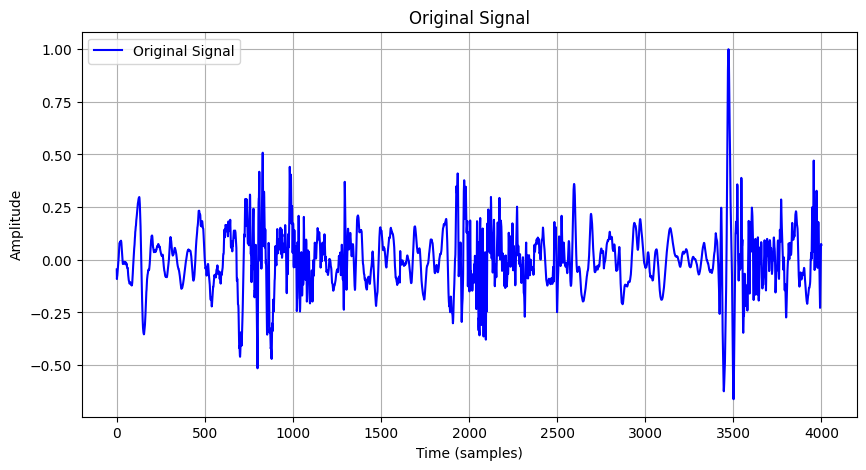

In [6]:
import matplotlib.pyplot as plt

# Assuming reconstructed_signal is a 1D NumPy array
plt.figure(figsize=(10, 5))
plt.plot(data, color='b', label='Original Signal')
plt.title("Original Signal")
plt.xlabel("Time (samples)")
plt.ylabel("Amplitude")
plt.grid(True)
plt.legend()
plt.show()

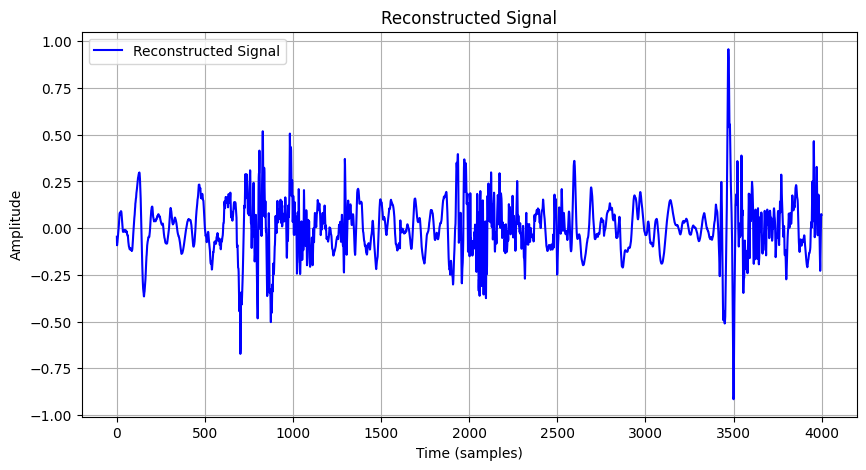

In [5]:
import matplotlib.pyplot as plt

# Assuming reconstructed_signal is a 1D NumPy array
plt.figure(figsize=(10, 5))
plt.plot(reconstructed_signal, color='b', label='Reconstructed Signal')
plt.title("Reconstructed Signal")
plt.xlabel("Time (samples)")
plt.ylabel("Amplitude")
plt.grid(True)
plt.legend()
plt.show()
